<a href="https://colab.research.google.com/github/Hyungguk/reddit_response_bot/blob/main/text2reply_USE_sampled_softmax__bidir%2Bame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the latest Tensorflow version.
#!pip install --upgrade pip
#!pip install tensorflow==2.0.0-rc1
# Install TF-Hub.
!pip install --quiet tensorflow-hub
!pip install --quiet seaborn


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/text2reply

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/text2reply


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


###Bigquery에서 공개되어 있는 reddit data를 불러온다.###

In [ ]:
%%bigquery --project platfarm df
SELECT text, response
from `reddit.text2reply.text2response_common`
#where MOD(ABS(FARM_FINGERPRINT(CONCAT(text, response))), 1000) < 30


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
split = len(df)*95//100
train_df = df[:split]
val_df = df[split:].reset_index(drop=True)

print(len(train_df))
print(len(val_df))


1481707
77985


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [ ]:
print("Version: ", tf.__version__)
print("Eager Execution: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU ", "Available" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  1.15.0
즉시 실행 모드:  False
허브 버전:  0.6.0
GPU  사용 가능


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder-multilingual/1", "https://tfhub.dev/google/universal-sentence-encoder-lite/2", "https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.layers import Embedding, Dense, Dot, InputLayer
from tensorflow.keras.models import Model
import keras.backend.tensorflow_backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.linalg import matmul, tensor_diag, normalize, matrix_transpose
from tensorflow.keras.activations import softmax
#import tf_sentencepiece

#disable_eager_execution()

BATCH_SIZE = 8
MARGIN = 0.2

embed = hub.Module(module_url)

def UniversalEmbedding(x):
    return embed((tf.cast(x, tf.string)))
  
def sampledSoftmax_ame(XY):
    x = XY[0]
    y = XY[1]
    M = matmul(x, y, transpose_b=True)
    d = np.full(BATCH_SIZE, MARGIN, dtype='float32')
    AM = tensor_diag(d)
    return softmax(M), softmax(matrix_transpose(M))

input_text = Input(shape=[], dtype=tf.string, name="text_input")
response_text = Input(shape=[], dtype=tf.string, name="response_input")

USE = Lambda(UniversalEmbedding, output_shape=(512, ), name="USE")

text_embedding = USE(input_text)
#text_embedding = Dense(512, activation='relu')(text_embedding)

response_embedding = USE(response_text)

#response_embedding = Dense(512, activation='relu')(response_embedding)
response_embedding = Dense(512, activation='relu')(response_embedding)
response_embedding = Dense(512, activation='relu')(response_embedding)

pred_response, pred_question = Lambda(sampledSoftmax_ame, output_shape=(BATCH_SIZE, ), name="sampled_softmax")([text_embedding, response_embedding])

text_encoder = Model(inputs=[input_text], outputs=text_embedding)
response_encoder = Model(inputs=[response_text], outputs=response_embedding)
model = Model(inputs=[input_text, response_text], outputs=[pred_response, pred_question])


Using TensorFlow backend.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
response_input (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
USE (Lambda)                    (None, 512)          0           text_input[0][0]                 
                                                                 response_input[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          262656      USE[1][0]                  

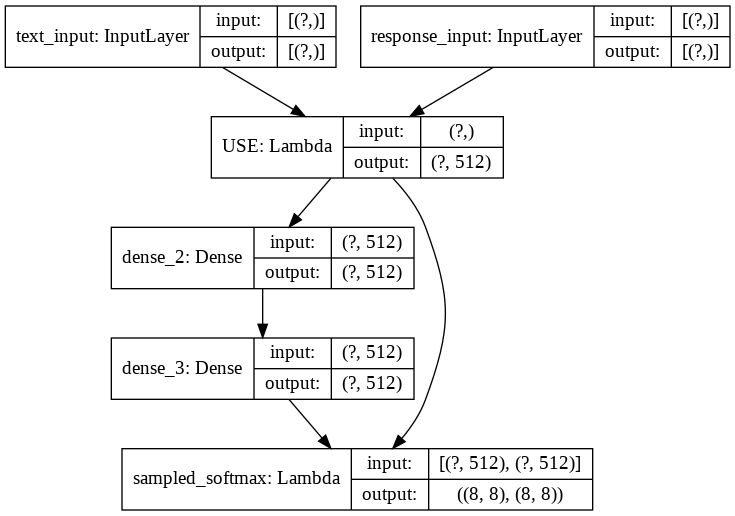

In [ ]:
from tensorflow.keras.utils import plot_model

#plot_model(text_encoder, show_shapes=True)
#plot_model(response_encoder, show_shapes=True)
plot_model(model, show_shapes=True)

In [ ]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical


class DataGenerator(keras.utils.Sequence):
    'Generate batches with negative sampling'
    def __init__(self, data, batch_size=8, dim=(8,2), shuffle=True):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data)) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X_q, X_a, score1, score2 = self.__data_generation(indexes)

        return [X_q, X_a], [score1, score2]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X_q = np.empty((self.batch_size), dtype=object)
        X_a = np.empty((self.batch_size), dtype=object)
        
        # Generate data
        for i in range(self.batch_size):
            # One question per batch.
            X_q[i] = self.data.loc[indexes[i]]['text']
            X_a[i] = self.data.loc[indexes[i]]['response']
            
        d = np.ones(self.batch_size)
        S = np.diag(d)
          
        return X_q, X_a, S, S

### DataGenerator를 만든다. ###

In [ ]:
val_neg_sample_generator = DataGenerator(val_df)
train_neg_sample_generator = DataGenerator(train_df)
#reverse_train_neg_sample_generator = ReverseDataGenerator(train_df)

In [ ]:
print(len(train_neg_sample_generator))
print(len(val_neg_sample_generator))
print("train", train_neg_sample_generator[14])
print("val", val_neg_sample_generator[5])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

import os

MODEL_SAVE_FOLDER_PATH = './saved_models/USE/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)


checkpointer = ModelCheckpoint(filepath=MODEL_SAVE_FOLDER_PATH + "bi+ame_weights.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())  
    session.run(tf.compat.v1.tables_initializer())
    model.load_weights('./saved_models/USE/bi+ame_weights.01-2.28.hdf5')
    history = model.fit_generator(generator=train_neg_sample_generator, validation_data=val_neg_sample_generator, epochs=20,
                                  callbacks=[checkpointer, earlystopper, tensorboard], verbose=1)


Epoch 1/20
128573/185213 [===================>..........] - ETA: 47:32 - loss: 2.0562 - sampled_softmax_loss: 1.0131 - sampled_softmax_1_loss: 1.0431 - sampled_softmax_categorical_accuracy: 0.6492 - sampled_softmax_1_categorical_accuracy: 0.6394

Inference Check

In [ ]:
test_texts = ["how are you?", "how are you?", 'hi', 'my two favorites in one pic!', 'are u hungry', 'I love you', 'I love you', 'How was the interview?']
test_replies = ["i'm fine", "what the heck", 'hi', 'same!', 'yeah, are you?', 'me too', 'love you too', 'Not bad']


with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    model.load_weights('./saved_models/ame/bi+ame_weights.05-4.20.hdf5')
    #model.save('test.h5')
    #tf.keras.models.save_model(model, 'test_model2.hdf5')
    predicts = model.predict([test_texts, test_replies])
    print(predicts)
    print(np.argmax(predicts, axis=1))

[array([[0.1318786 , 0.11589426, 0.14621902, 0.10914388, 0.14105228,
        0.11116765, 0.12305306, 0.1215913 ],
       [0.15976834, 0.09411536, 0.14503117, 0.10825722, 0.1399064 ,
        0.11026455, 0.12205341, 0.12060352],
       [0.12936431, 0.13486777, 0.15037538, 0.11023569, 0.12299573,
        0.11453302, 0.12948254, 0.10814554],
       [0.1176386 , 0.1401421 , 0.14238839, 0.10222913, 0.10907435,
        0.13162743, 0.1341769 , 0.12272313],
       [0.15199402, 0.12888831, 0.13469428, 0.10435548, 0.12941463,
        0.10564206, 0.12317179, 0.12183944],
       [0.1255182 , 0.12923707, 0.13712157, 0.11755872, 0.11496849,
        0.10657954, 0.16747205, 0.10154438],
       [0.12637255, 0.13011673, 0.13805489, 0.11835888, 0.11575104,
        0.1310626 , 0.13804778, 0.10223555],
       [0.14504822, 0.11905232, 0.12833887, 0.1211056 , 0.13475943,
        0.12297557, 0.12194801, 0.10677201]], dtype=float32), array([[0.12392595, 0.15136349, 0.12506217, 0.1050247 , 0.1318286 ,
        0.

In [ ]:
with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    model2 = tf.keras.models.load_model('test.h5')
    predicts = model2.predict([test_texts, test_replies])
    print(predicts)
    print(np.argmax(predicts, axis=1))

In [ ]:
responses = df['response'].tolist()
print(len(responses))

47040


In [ ]:
print(responses[:20])

['Ah!', 'Go.', 'Go?', 'Hi.', 'Me.', 'Me?', 'No!', 'No!', 'No!', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.', 'No.']


In [ ]:
import time

embeddings = []

with tf.compat.v1.Session() as session:
    K.set_session(session)
    session.run(tf.compat.v1.global_variables_initializer())
    session.run(tf.compat.v1.tables_initializer())
    model.load_weights('./saved_models/3/weights.03-1.11.hdf5')
    start = time.time()
    embeddings = response_encoder.predict([responses])
    print(time.time() - start)


52.04889154434204


### Clustering Using Spherical Clustering ###
학습 한 모델로 답변들을 클러스터링을 한 후, 해당 답변들을 클러스터링 한다. 



In [ ]:
!pip install soyclustering

In [ ]:
from soyclustering import SphericalKMeans
from scipy.sparse import csr_matrix

embed_matrix = csr_matrix(embeddings)

number_of_clusters = 800

spherical_kmeans = SphericalKMeans(
    n_clusters=number_of_clusters,
    max_iter=20,
    verbose=1,
    init='similar_cut'
)
labels = spherical_kmeans.fit_predict(embed_matrix)
cluster = {}
for i in range(len(labels)):
    if labels[i] in cluster:
        cluster[labels[i]].append(responses[i])
    else:
        cluster[labels[i]] = [responses[i]]

cluster_centers = spherical_kmeans.cluster_centers_
print(labels)
print(cluster_centers)

initialization_time=0.114837 sec, sparsity=0.656
n_iter=1, changed=46553, inertia=2366.046, iter_time=19.640 sec, sparsity=0.705
n_iter=2, changed=13023, inertia=1711.356, iter_time=22.415 sec, sparsity=0.706
n_iter=3, changed=6228, inertia=1638.976, iter_time=22.659 sec, sparsity=0.706
n_iter=4, changed=3845, inertia=1609.464, iter_time=22.433 sec, sparsity=0.706
n_iter=5, changed=2615, inertia=1593.375, iter_time=22.613 sec, sparsity=0.706
n_iter=6, changed=1856, inertia=1583.584, iter_time=22.403 sec, sparsity=0.706
n_iter=7, changed=1416, inertia=1576.666, iter_time=22.662 sec, sparsity=0.706
n_iter=8, changed=1104, inertia=1571.807, iter_time=22.453 sec, sparsity=0.706
n_iter=9, changed=876, inertia=1568.227, iter_time=22.606 sec, sparsity=0.706
n_iter=10, changed=662, inertia=1565.662, iter_time=22.427 sec, sparsity=0.706
n_iter=11, changed=556, inertia=1563.801, iter_time=22.592 sec, sparsity=0.706
n_iter=12, changed=448, inertia=1562.294, iter_time=22.351 sec, sparsity=0.706
n_

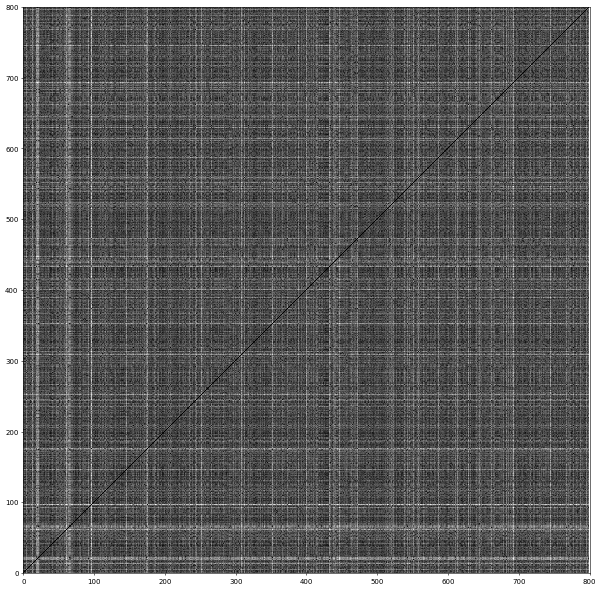

In [ ]:
from soyclustering import visualize_pairwise_distance

fig = visualize_pairwise_distance(cluster_centers, max_dist=.7, sort=True)

In [ ]:
from scipy.spatial.distance import cosine

center_indices = []
for center in cluster_centers:
    min_dis = None
    min_idx = None
    i = 0
    for vector in embeddings:
        if min_idx == None:
            min_idx = i
            min_dis = cosine(center, vector)
        elif cosine(center, vector) < min_dis:
            min_dis = cosine(center, vector)
            min_idx = i
        i += 1
    center_indices.append(min_idx)

center_texts = [responses[idx] for idx in center_indices]

In [ ]:
print(center_indices)
print(center_texts)
print(cluster[3])
#print(cluster_centers)

[379, 4105, 17423, 22256, 40011, 104, 40864, 19715, 35616, 881, 41282, 21781, 341, 22519, 165, 11444, 44652, 45461, 11673, 4875, 628, 4540, 699, 41960, 69, 1362, 14296, 8818, 31400, 1787, 16229, 11960, 27666, 43210, 20193, 12336, 14673, 395, 27836, 1213, 24724, 19251, 18821, 46485, 43522, 6, 20929, 14832, 23504, 15757, 35416, 9935, 16762, 13700, 1225, 11642, 23205, 45973, 31915, 30433, 2490, 26110, 5107, 2029, 7350, 18461, 4324, 21495, 33891, 11490, 297, 25282, 15662, 42261, 653, 39692, 619, 31824, 21405, 19154, 2419, 2538, 45538, 28401, 27522, 21303, 33319, 45459, 15434, 42065, 9624, 14343, 37338, 1940, 40718, 41151, 436, 29529, 3400, 22218, 44530, 2167, 527, 11053, 17357, 17398, 855, 33810, 11033, 10195, 13954, 20781, 31501, 24650, 3066, 31965, 17004, 24822, 1845, 24814, 16630, 4179, 42368, 36301, 46455, 1934, 5339, 24444, 803, 27021, 17716, 20462, 22419, 37911, 21413, 22891, 30493, 1462, 86, 10194, 60, 25315, 34788, 14730, 1910, 13758, 45050, 54, 36596, 4, 17448, 1733, 4251, 3085, 2

In [ ]:
data = {"clusters":list(cluster.keys()), "responses":list(cluster.values())}
df = pd.DataFrame(data)
df.sort_values(by="clusters", inplace=True)
df["representative_text"] = center_texts

str_cluster_centers = [" ".join(map(str, a)) for a in cluster_centers]
df["cluster_centers"] = str_cluster_centers
#df.head(30)


In [ ]:
df.to_csv("sampled-softmax_n_cluster=800_rep.csv", index=False)

### Response Retrieval Using Nearest Neighbor Search

In [ ]:
df = pd.read_csv('sampled-softmax_n_cluster=800_rep.csv')

In [ ]:
#import faiss
import time
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine


reply_clusters = pd.read_csv('n_cluster=800_rep2.csv')
reply_clusters.set_index("clusters", inplace=True, drop=False)

start = time.time()
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("./encoders/universal-sentence-encoder-large")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

session = tf.Session(graph=g)
session.run(init_op)
print(time.time()-start)

def retrieve_best_response(text):
    start = time.time()
    embedding = session.run(embedded_text, feed_dict={text_input: [text]})
    #print(time.time() - start)

    min_idx = None
    min_dis = None
    for i in reply_clusters["clusters"].tolist():
        vector = [float(v) for v in reply_clusters.loc[i]["cluster_centers"].split(' ')]
        if min_idx == None:
            min_idx = i
            min_dis = cosine(embedding, vector)
        elif cosine(embedding, vector) > min_dis:
            min_dis = cosine(embedding, vector)
            min_idx = i
    print(min_dis)
    #print(time.time() - start)
    return reply_clusters.loc[min_idx]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


32.41901874542236


In [ ]:
print(reply_clusters.loc[1]["cluster_centers"].split(' '))

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.06290922801525356', '0.0', '0.0', '0.17000620814197226', '0.0', '0.0', '0.15603865677677126', '0.015363995817544274', '0.0', '0.0462737463663192', '0.0', '0.0', '0.07056093132670195', '0.0', '0.0', '0.02707562602369165', '0.0', '0.0', '0.011905113473640724', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.12495388121321185', '0.0', '0.0', '0.07793394370634382', '0.0', '0.0', '0.0', '0.0', '0.0', '0.06923041694676181', '0.0', '0.0', '0.0', '0.04214090984305909', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.07559666808929076', '0.0', '0.031654197522805606', '0.0', '0.07451481665420837', '0.20528158436499436', '0.010196736327615584', '0.028240370887230692', '0.01102170180245371', '0.09437629251063541', '0.0', '0.013919123649772007', '0.022105777427268183', '0.08577771631102044', '0.0', '0.02968155530607643', '0.0', '0.0', '0.0', '0.0', '0.01794882025154663'

In [ ]:
retrieve_best_response("you are smart")["responses"]

1.0877725486417398


'[\'i appreciate that\', \'thanks! i placenta it!\', \'lol, thanks\', \'ha! thank you!\', \'not that impressive rly but thanks\', \'haha thanks :p\', \'thank you that really brightened my day!!!\', "aww that\'s nice, thanks man lol", \'thanks for noticing\', \'thanks for the compliment\', \'thanks lol\', \'lmao thanks\', \'thanks lol\', "thanks, i\'m a bot, so", \'thank you my inspiration\', \'thanks, i jizzed it myself\', \'thanks man, i try\', \'jk thank u\', \'aww thanks man i wonr\', \'thanks uncee dana xx\', \'i know! :d thank you for that!\', \'thanks i think\', \'well thanks!\', \'thanks ikr\', \'thank you lol\', \'thanks lol\', \'always nice when someone agrees, thank you\', \'thanks i hate it\', \'lol appreciate it\', \'thank you bb\', \'thank you! college of art and science\', \'thanks i like it to\', \'thank-you for rewarding the comment\', \'thanks, i appreciate it haha\', \'thank you king-dono i appreciate that!\', \'aw thanks, have an up vote!\', \'thanks lol\', \'lol ty\